In [44]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt

## We base our first iteration on Unicycle Kinematics.
## https://www.mathworks.com/help/robotics/ug/mobile-robot-kinematics-equations.html
## x = [x,y,heading]^T
## u = [wheel_speed, heading_rate (rad/s)]^T


## Some constants
r = 0.1 # wheel radius

## Define our model
# x_dot = A*x + B*u
A = np.identity(3)
def B(r,x):
    B = np.array([[r*np.cos(x[2]), 0],
                  [r*np.sin(x[2]), 0],
                  [0, 1]])
    return B


In [45]:
## Tuning parameters
v_k = np.array([1.0,1.0,1.0]) # process noise

w_k = np.array([1.0,1.0,1.0]) # sensor noise

Q_k = np.array([[0.5,   0,   0], # model noise covariance matrix
                [  0, 0.5,   0],
                [  0,   0, 0.5]])

H_k = np.array([[1.0,  0,   0], # observation matrix
               [  0, 1.0,   0],
               [  0,  0, 1.0]])

R_k = np.array([[1.0,   0,    0], # observation/estimate noise covariance matrix
                [  0, 1.0,    0],
                [  0,    0, 1.0]])


In [46]:
## EKF function
def EKF(z_k, x_k_min_1, u_k_min_1, P_k_min_1, T):
    
    # z_k: observation vector
    # x_k_min_1: previous state estimate
    # u_k_min_1: previous input
    # P_k_min_1: previous covariance matrix
    # T: time
    
    # Prediction phase
    x_k = A @ x_k_min_1 + B(r,x_k_min_1) @ (u_k_min_1) + w_k # predicted state estimate
    
    P_k = A @ P_k_min_1 @ A.T + Q_k # updated covariance matrix (pre-correction)
    
    
    # Correction phase
    S_k = H_k @ P_k @ H_k.T + R_k
    
    y_k_hat = z_k - (H_k @ x_k + v_k) # measurement estimate
    
    K_k = P_k @ H_k.T @ inv(S_k) # near-optimal Kalman gain
    
    x_k_hat = x_k + K_k @ y_k_hat # updated state estimate prediction
    
    P_k = (np.identity(3) - K_k @ H_k) @ P_k # updated covariance matrix (post-correction)
    
    # Returning state estimate and covariance
    return x_k_hat, P_k

In [107]:
def simulate_robot():
    
    # Constants
    t_0 = 1 # time interval start
    T = 10 # total time interval
    
    # Initial values
    #z_k = np.array([[4.721,0.143,0.006], # k=1
    #                [9.353,0.284,0.007], # k=2
    #                [14.773,0.422,0.009],# k=3
    #                [18.246,0.555,0.011], # k=4
    #                [22.609,0.715,0.012]])# k=5
    
    z_k = [] # sensor measurements
    
    x = []
    y = []
    yaw = []
    
    #init for 1Hz measurements
    x_1hz = []
    y_1hz = []
    
    #Init for 100hz measurements
    x_100hz = []
    y_100hz = []
    yaw_100hz = []
    
    #noise = np.random.normal(0,1,100)
    
    for i in range(0,25):
        new_x = i*0.1
        new_y = new_x*new_x
        z_k.append([new_x,new_y,0.0])
        x.append(new_x)
        y.append(new_y)
        yaw.append(0.0)
    
    #create sensordata
    h = 10/1000
    
    
    z_k_1hz = []
    #Get position sensor data with 1 Hz
    for i in range(0,10):
        new_x = i
        new_y = np.sin(i)
        x_1hz.append(new_x)
        y_1hz.append(new_y)
        z_k_1hz.append([new_x,new_y,0.0])
        
    
    #Initialize values for integration
    z_yaw = 0
    z_y_dot = 0
    z_y = 0
    z_x_dot = 0
    z_x = 0
    
    z_k_100hz = []
    
    #Get angular rate and linear acceleration sensor data with 100 Hz
    t = []
    for i in range(0,1000):
        t.append(i*0.01)
        x_100hz.append(z_x)
        y_100hz.append(z_y)
        yaw_100hz.append(z_yaw)
        
        z_k_100hz.append([z_x,z_y,z_yaw])
        
        z_x_ddot = 0;
        z_y_ddot = -np.sin(i*0.01)
        z_yaw_dot = -np.sin(i*0.01)
        
        z_x_dot = z_x_dot + h * z_x_ddot
        z_y_dot = z_y_dot + h * z_y_ddot
        z_x = z_x + h * z_x_dot
        z_y = z_y + h * z_y_dot
        
        z_yaw = z_yaw + h * z_yaw_dot
    
    
    
    x_k_min_1 = np.array([0.0,0.0,0.0]) # initial state
    u_k_min_1 = np.array([0.0,0.0]) # initial input
    #u_k_min_1 = np.array([5,2]) # initial input
    P_k_min_1 = np.array([[0.1, 0, 0], # initial covariance
                          [0, 0.1, 0],
                          [0, 0, 0.1]])
    
    x_hat = []
    y_hat = []
    yaw_hat = []
    
    #Iterate
    """
    for k, z_k_obs in enumerate(z_k,start=t_0):
        
        x_k_hat, P_k = EKF(z_k_obs, x_k_min_1,u_k_min_1,P_k_min_1,T)
         
        # Get ready for the next timestep by updating the variable values
        x_k_min_1 = x_k_hat
        P_k_min_1 = P_k
        
        x_hat.append(x_k_hat[0])
        y_hat.append(x_k_hat[1])
        yaw_hat.append(x_k_hat[2])
    """
    #print(z_k_100hz)
    for k, z_k_obs in enumerate(z_k_100hz,start=t_0):
        
        #use position estimates every second
        if k%100 == 0:
            print("testing")
            z = [z_k_1hz[int(k*0.01)-1][0],z_k_1hz[int(k*0.01)-1][1], z_k_obs[2]]
            print(z)
            x_k_hat, P_k = EKF(z, x_k_min_1,u_k_min_1,P_k_min_1,T)
        #otherwise use rate and acceleration measurements
        else:
            x_k_hat, P_k = EKF(z_k_obs, x_k_min_1,u_k_min_1,P_k_min_1,T)
         
        # Get ready for the next timestep by updating the variable values
        x_k_min_1 = x_k_hat
        P_k_min_1 = P_k
        
        x_hat.append(x_k_hat[0])
        y_hat.append(x_k_hat[1])
        yaw_hat.append(x_k_hat[2])
    

    #plt.plot(x, y, label="trajectory")
    #print("x:    ", y_hat)
    #print("y:    ", y_100hz)
    
    plt.plot(x_100hz, y_100hz,  label="trajectory")
    plt.plot(x_hat,y_hat, label="trajectory_hat")
    plt.legend()
    plt.show()
    
    plt.plot(t, yaw_100hz, label="yaw")
    plt.plot(t, yaw_hat, label="yaw_hat")
    plt.legend()
    plt.show()
    
    plt.plot(x_1hz, y_1hz, label="1hz measurements")
    plt.legend()
    plt.show()

testing
[0, 0.0, -0.4471262486013132]
testing
[1, 0.8414709848078965, -1.402454414556296]
testing
[2, 0.9092974268256817, -1.9877601861408396]
testing
[3, 0.1411200080598672, -1.664916136235977]
testing
[4, -0.7568024953079282, -0.7307435954526211]
testing
[5, -0.9589242746631385, -0.04411648962959193]
testing
[6, -0.27941549819892586, -0.23631661331744808]
testing
[7, 0.6569865987187891, -1.1306360591738578]
testing
[8, 0.9893582466233818, -1.9048416530438705]
testing
[9, 0.4121184852417566, -1.8471323423554238]


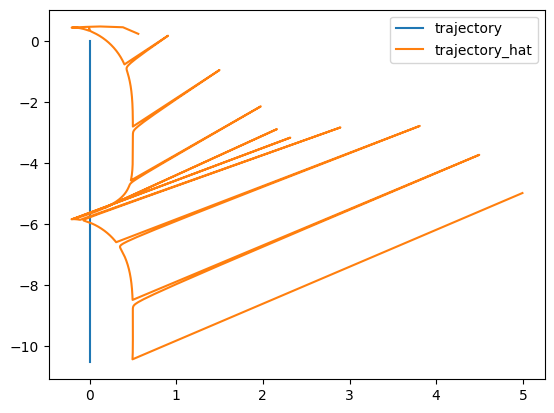

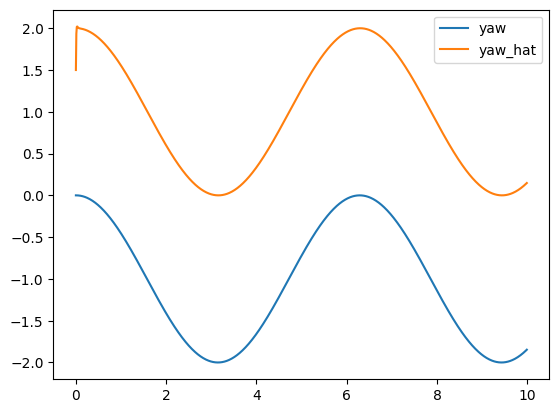

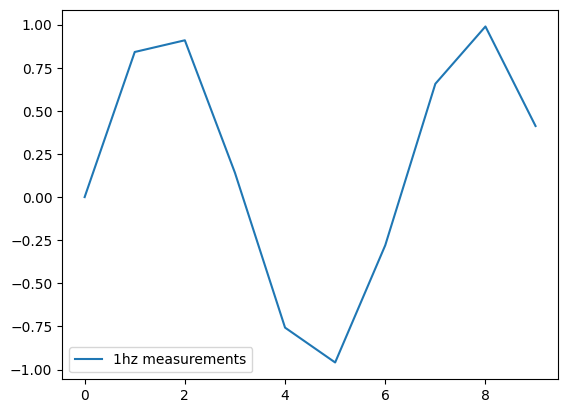

In [108]:
simulate_robot()